# A foray into LSTM encoding

Another way of extracting vector representations from text is by using the hidden state of an LSTM RNN

It has several potential advantages:
- Works much faster, uses much less memory
- Said to excel at infering dependences on small datasets
- Naturally supports variable-length input (operates on sequences)

**Here**, we attempt (and fail) to fine-tune the [navec](https://github.com/natasha/navec) word embeddings on the provided files, and use them to generate per-section sequence embeddings, which we compare in both the cosine-similarity and clustering approaches

## Loading natasha toolkit

This includes pretrained embeddings, a tokenizer and a custom torch layer

In [1]:
!pip install slovnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


In [2]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-10-31 17:44:25--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.0MB/s    in 3.7s    

2024-10-31 17:44:29 (13.5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [8]:
import razdel # The tokenizer (in the old sense, a word segmenter)

In [9]:
list(razdel.tokenize('''Я вот что скажу: вообще не
понятно, как можно не любить стволы родных берез? '''))

[Substring(0, 1, 'Я'),
 Substring(2, 5, 'вот'),
 Substring(6, 9, 'что'),
 Substring(10, 15, 'скажу'),
 Substring(15, 16, ':'),
 Substring(17, 23, 'вообще'),
 Substring(24, 26, 'не'),
 Substring(27, 34, 'понятно'),
 Substring(34, 35, ','),
 Substring(36, 39, 'как'),
 Substring(40, 45, 'можно'),
 Substring(46, 48, 'не'),
 Substring(49, 55, 'любить'),
 Substring(56, 62, 'стволы'),
 Substring(63, 69, 'родных'),
 Substring(70, 75, 'берез'),
 Substring(75, 76, '?')]

In [3]:
# The embeddings
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [4]:
navec['кожевенник'].shape

(300,)

In [10]:
# The proper tokenizer
navec.vocab['кожевенник']

173846

In [11]:
# Set size parameters for model construction later on

vocab_size = 500000  # Example vocabulary size
embed_dim = 300      # Embedding size
hidden_dim = 500     # LSTM hidden state size
n_layers = 1         # No of layers

## Training LSTM

This depends to a large extent on the code from a [seminar](https://github.com/girafe-ai/ml-course/blob/master/week0_09_embeddings_and_seq2seq/week09_seq2seq_rnn_practice_solved.ipynb) of the giraffe-ai Basic ML course

In [104]:
# Extract list of all sections from pickled file
import pickle

with open('doc_texts.txt', 'rb') as dumpfile:
  texts = pickle.load(dumpfile)

# Many empty strings - parsing artifact
texts = list(filter(lambda x: x != '', texts))

# Use sentences as sequences
sentences = []
for par in texts:
  sentences += [sent.text for sent in razdel.sentenize(par)]
texts = sentences

In [105]:
import torch
import torch.nn as nn

from slovnet.model.emb import NavecEmbedding # Inherits nn.Embedding
import numpy as np

In [106]:
# Check consistency
navec_emb = NavecEmbedding(navec)
assert(np.all(
    navec['кожевенник'] == navec_emb(torch.tensor(navec.vocab['кожевенник'])).numpy()
))
print('Layer produces same embeddings from a token as does the dictionary from the corresponding string')

Layer produces same embeddings from a token as does the dictionary from the corresponding string


In [139]:
class LSTMRegressor(nn.Module):
    def __init__(self, navec, vocab_size, embed_size, rnn_num_units=300):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = NavecEmbedding(navec)
        self.rnn_update = nn.Linear(embed_size + rnn_num_units, rnn_num_units)
        self.rnn_to_embedding = nn.Linear(rnn_num_units, embed_size)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of word embeddings, each containing
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)

        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next) #YOUR CODE HERE

        assert h_next.size() == h_prev.size()

        # compute output embedding
        emb = self.rnn_to_embedding(h_next) #YOUR CODE

        return h_next, emb

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [174]:
model = LSTMRegressor(navec, vocab_size, embed_dim)

In [175]:
def tokenize_filter(seqs):
  seqs = [txt.lower() for txt in seqs]
  token_seq = []
  for txt in seqs:
    token_seq.append([tkn.text for tkn in razdel.tokenize(txt) if tkn.text in navec])
  return token_seq

In [176]:
import string

def to_matrix(
    seqs, max_len=None, pad=navec['<pad>'], dtype='int32', batch_first=True
    ):
    """Casts a list of sequences into rnn-digestable matrix"""

    sequences = tokenize_filter(seqs)

    max_len = max_len or max(map(len, sequences))
    max_len += 1
    seqs_ix = np.zeros([len(seqs), max_len, embed_dim], dtype) + pad
    seqs_ix[:, 0, :] = navec['сос'] # <SOS> - a word we will never see in the corpus

    for i in range(len(seqs)):
        line_ix = [navec[c] for c in sequences[i]]
        # print(seqs_ix.shape, np.shape(line_ix))
        seqs_ix[i, 1:len(line_ix), :] = line_ix[1:]
        seqs_ix[i, len(line_ix), :] = navec['сас'] # <EOS> - a word we will never see in the corpus


    if not batch_first: # convert [batch, time] into [time, batch]
        seqs_ix = np.transpose(seqs_ix)

    # Additionally, prepare token matrix
    sequences = [seq + ['<pad>'] * (max_len - len(seq)) for seq in sequences]
    toks_ix = np.array([[navec.vocab[wrd] for wrd in seq] for seq in sequences])

    #print(seqs_ix.shape, toks_ix.shape, '\n\n')

    return seqs_ix, toks_ix

In [177]:
def rnn_loop(char_rnn, batch_ix, tok_batch):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, _ = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in tok_batch.transpose():
        #print(x_t.shape)
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)

    return torch.stack(logits, dim=1)

In [199]:
import torch.optim as optim

num_epochs = 1000

#opt = optim.Adam(model.parameters(), lr=0.05)
opt = optim.SGD(model.parameters(), lr=0.005, momentum=0.7)
loss_func = nn.CosineEmbeddingLoss()

history = []

In [200]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import sample

In [201]:
len(texts)

2341

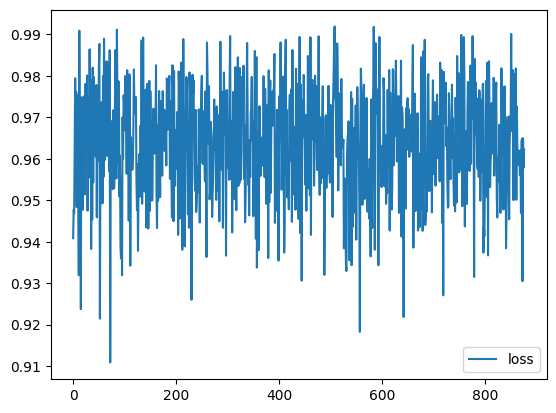

100%|██████████| 1000/1000 [02:20<00:00,  7.13it/s]


In [202]:
for epoch in tqdm(range(num_epochs)):
    # Plot dynamic loss value
    if (epoch+1)%100==0:
          clear_output(True)
          plt.plot(history,label='loss')
          plt.legend()
          plt.show()
    try:
      batch_ix, tok_batch = to_matrix(sample(texts, 32))
    except ValueError:
      continue
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    embedding_seq = rnn_loop(model, batch_ix, tok_batch)
    batch_size, max_length, _ = batch_ix.size()

    # compute loss
    #<YOUR CODE>
    predictions_embeddings = embedding_seq[:, :-1, :]
    actual_next_embeddings = batch_ix[:, 1:, :]
    cos_sim_targets = torch.ones(batch_size * (max_length -1))

    loss = loss_func(
    predictions_embeddings.reshape((-1, embed_dim)),
    actual_next_embeddings.reshape((-1, embed_dim)),
    cos_sim_targets
    )
    loss.backward()
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
from navec import vocab
from navec.tar import Tar
VOCAB = 'vocab.bin'
with Tar('navec_hudlit_v1_12B_500K_300d_100q.tar') as tar:
  voc = vocab.Vocab.from_file(tar.load(VOCAB))